In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from sklearn.model_selection import train_test_split
from pathlib import Path

In [2]:
def read_lattices(directory):
    lattices = {}

    for filename in sorted(os.listdir(directory)):
        if filename.endswith('.txt'):
            file_path = os.path.join(directory, filename)

            order_number = int(filename.split('.')[0])

            if order_number < 5000:
                lattice_config = np.loadtxt(file_path)

                lattices[order_number] = lattice_config
        
    return lattices

In [3]:
def calculate_sin_cos(lattices):
    sin_values = {}
    cos_values = {}

    for i in range(0, len(lattices)):
        sin_values[i] = np.sin(lattices[i])
        cos_values[i] = np.cos(lattices[i])
        
    return sin_values, cos_values

In [4]:
def create_inputs_outputs(sin_values, cos_values, L):
    inputs = []
    outputs = []

    for step in range(len(sin_values) - 1):
        inputs_step = np.concatenate((sin_values[step].reshape(-1, L*L)[0], cos_values[step].reshape(-1, L*L)[0]))
        outputs_step = np.concatenate((sin_values[step + 1].reshape(-1, L*L)[0], cos_values[step + 1].reshape(-1, L*L)[0]))

        inputs.append(inputs_step)
        outputs.append(outputs_step)
        
    dataset = list(zip(inputs, outputs))
    return dataset

In [5]:
def save_npy_file(dataset, lat_size, temperature, simulation):
    dataset_np = np.array(dataset)
    
    if temperature == 0.001:
        temp = "0001"
        
    if temperature == 0.01:
        temp = "001"
    
    if temperature == 0.1:
        temp = "01"
    
    if temperature == 0.5:
        temp = "05"
        
    if temperature == 0.9:
        temp = "09"
    
#     Path(f"/new_frustrated_sim_{lat_size}_{temp}").mkdir(parents=True, exist_ok=True)

    directory = f"C:/Users/hmpor/Jupyter Notebooks/Thesis/new_frustrated_sim_{lat_size}_{temp}"
    
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    file_path = f"new_frustrated_sim_{lat_size}_{temp}/dataset_{lat_size}_{temperature}_{simulation}.npy"
    
    np.save(file_path, dataset_np)

In [12]:
directory = "C:/Users/hmpor/Jupyter Notebooks/Thesis/frustrated_results_8x8_new"

In [6]:
temperatures = [0.1]
lattice_sizes = [8]

for i in range(100):
    for lat_size in lattice_sizes:
        for temp in temperatures:
            directory = f"C:/Users/hmpor/Jupyter Notebooks/Thesis/frustrated_results_{lat_size}x{lat_size}_new"
            directory_path = f"{directory}/{i}/{lat_size}/{temp}"
            print(directory_path)
            
            lattices = read_lattices(directory_path)
            
            sin_values, cos_values = calculate_sin_cos(lattices)
            
            dataset = create_inputs_outputs(sin_values, cos_values, lat_size)
            
            save_npy_file(dataset, lat_size, temp, i)

C:/Users/hmpor/Jupyter Notebooks/Thesis/results_8x8/0/8/0.1
C:/Users/hmpor/Jupyter Notebooks/Thesis/results_8x8/0/8/0.5
C:/Users/hmpor/Jupyter Notebooks/Thesis/results_8x8/0/8/0.9
C:/Users/hmpor/Jupyter Notebooks/Thesis/results_8x8/1/8/0.1
C:/Users/hmpor/Jupyter Notebooks/Thesis/results_8x8/1/8/0.5
C:/Users/hmpor/Jupyter Notebooks/Thesis/results_8x8/1/8/0.9
C:/Users/hmpor/Jupyter Notebooks/Thesis/results_8x8/2/8/0.1
C:/Users/hmpor/Jupyter Notebooks/Thesis/results_8x8/2/8/0.5
C:/Users/hmpor/Jupyter Notebooks/Thesis/results_8x8/2/8/0.9
C:/Users/hmpor/Jupyter Notebooks/Thesis/results_8x8/3/8/0.1
C:/Users/hmpor/Jupyter Notebooks/Thesis/results_8x8/3/8/0.5
C:/Users/hmpor/Jupyter Notebooks/Thesis/results_8x8/3/8/0.9
C:/Users/hmpor/Jupyter Notebooks/Thesis/results_8x8/4/8/0.1
C:/Users/hmpor/Jupyter Notebooks/Thesis/results_8x8/4/8/0.5
C:/Users/hmpor/Jupyter Notebooks/Thesis/results_8x8/4/8/0.9
C:/Users/hmpor/Jupyter Notebooks/Thesis/results_8x8/5/8/0.1
C:/Users/hmpor/Jupyter Notebooks/Thesis/

FileNotFoundError: [WinError 3] System nie może odnaleźć określonej ścieżki: 'C:/Users/hmpor/Jupyter Notebooks/Thesis/results_8x8/20/8/0.1'

In [ ]:
folder_path = "C:/Users/hmpor/Jupyter Notebooks/Thesis/new_frustrated_sim_16_0001"  

npy_files = glob.glob(os.path.join(folder_path, "*.npy"))

dataset = []

for npy_file in npy_files:
    data = np.load(npy_file)
    dataset.append(data) 
    
combined_dataset = np.concatenate(dataset, axis=0)  # Concatenate along the first axis

print("Combined dataset shape:", combined_dataset.shape)

In [ ]:
np.save("new_frustrated_dataset_8_01.npy", combined_dataset)

In [22]:
directory = "C:/Users/hmpor/Jupyter Notebooks/Thesis/frustrated_results_8x8_new/10/8/0.1"

In [23]:
lattices = read_lattices(directory)

In [24]:
print(len(lattices[10]))
print(lattices[10][0][1])

8
-1.2427725034151225


In [25]:
def init_frustration(L, limit):
    return np.random.uniform(-limit, limit, (L, L, 4))

def calculate_lattice_energy(spins, L, J, neighbors_table, frustration):
    energy = 0.0
    for i in range(L):
        for j in range(L):
            theta = spins[i, j]
            for k in range(4):
                neighbor = neighbors_table[k, i, j]
                theta_neighbor = spins[neighbor]
                A_ij = frustration[i, j, k]
                interaction = -J * np.cos(theta - theta_neighbor + A_ij)
                energy += interaction
    return energy / 2

In [26]:
def create_neighbors_table(L):
    neighbor_table = np.empty((4, L, L), dtype=tuple)

    for i in range(L):
        for j in range(L):
            bottom_neighbor = ((i + 1) % L, j)
            top_neighbor = ((i - 1) % L, j)
            right_neighbor = (i, (j + 1) % L)
            left_neighbor = (i, (j - 1) % L)

            neighbor_table[0, i, j] = bottom_neighbor
            neighbor_table[1, i, j] = top_neighbor
            neighbor_table[2, i, j] = right_neighbor
            neighbor_table[3, i, j] = left_neighbor

    return neighbor_table

In [27]:
L = 8
J = 1

frustration = init_frustration(L, np.pi)
neighbors = create_neighbors_table(L)

In [28]:
energies = []

for i, lattice in enumerate(lattices):
    energy = calculate_lattice_energy(lattices[i], L, J, neighbors, frustration)
    energies.append(energy)

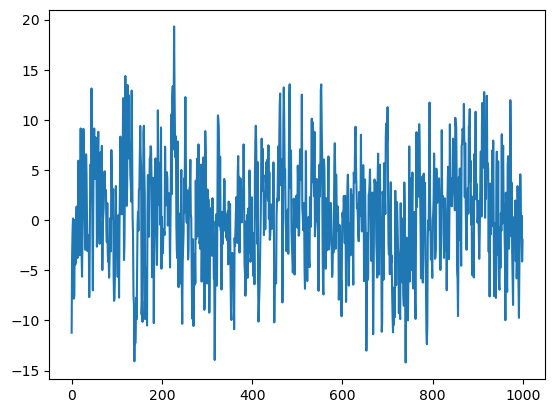

In [29]:
plt.plot(energies)

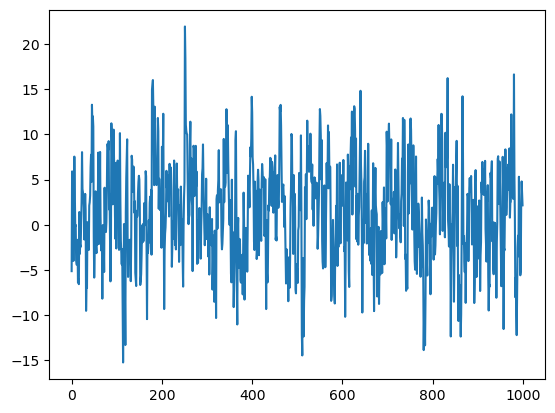

In [21]:
plt.plot(energies)